### REI505M Final project: Music genre classification starter pack

The following Dataset class operates on the GTZAN dataset.

* The duration of most GTZAN files are 30 seconds (3022050=661500 samples) but some are slightly shorter (approx 29.9 seconds). For this reason we truncate at 660000 samples below.
* It may be beneficial to work with smaller chunks than ~30 seconds.
* You may want to perform the data augmentations in the `__get_item__` function.
* For now, `train_dataset` contains all the dataset, you need to set aside some examples for validation and test sets.

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import scipy.io.wavfile as wav
import os
import numpy as np
import librosa
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math

audio_dir = 'music/'
#audio_dir = 'music/' # Path to folder with GTZAN files
# music/
#  - rock/
#       rock.00099.wav
#       ...
#  - reggie/
#  ...
#  - blues/

batch_size = 32
class AudioDataset(Dataset):
    def __init__(self, audio_files, labels, audio_path,
                 maxlen, sampling_rate, duration, augment=False):
        self.audio_files = audio_files
        self.audio_path = audio_path
        self.labels = labels
        self.maxlen = maxlen
        self.sampling_rate = sampling_rate
        self.duration = duration          # seconds
        self.augment = augment

        self.target_len = int(self.duration * self.sampling_rate)

    def __len__(self):
        return len(self.audio_files)

    def _crop_or_pad(self, x: torch.Tensor) -> torch.Tensor:
        """Ensure fixed length target_len via crop/pad. Crop start is random if augment=True."""
        if len(x) > self.maxlen:
            x = x[:self.maxlen]

        L = len(x)
        if L > self.target_len:
            if self.augment:
                start = torch.randint(0, L - self.target_len + 1, (1,)).item()
            else:
                start = (L - self.target_len) // 2
            x = x[start:start + self.target_len]
        elif L < self.target_len:
            pad = self.target_len - L
            x = torch.cat([x, torch.zeros(pad, dtype=x.dtype)], dim=0)

        return x

    def _augment_audio(self, x: torch.Tensor) -> torch.Tensor:
        """
        Augment with:
        - pitch shifting
        - time stretching
        - loudness (gain)
        - additive noise
        """
        x_np = x.numpy().astype(np.float32)

       #Pitch shift (random 2 semitones)\n",
       # if np.random.rand() < 0.7:
        #    n_steps = np.random.uniform(-2.0, 2.0)
         #   x_np = librosa.effects.pitch_shift(x_np, sr=self.sampling_rate, n_steps=n_steps)


        # Time stretch (0.8x–1.2x)
        #if np.random.rand() < 0.7 and len(x_np) > 2:
        #    rate = np.random.uniform(0.8, 1.2)
        #    x_np = librosa.effects.time_stretch(y=x_np, rate=rate)

        x = torch.from_numpy(x_np)

        # Loudness / gain
        if torch.rand(1).item() < 0.7:
            gain = 0.7 + 0.4 * torch.rand(1).item()  # 0.7x–1.3x
            x = x * gain

        # Additive Gaussian noise
        if torch.rand(1).item() < 0.7:
            std = x.std()
            if std > 0:
                noise_level = 0.01 * std
                noise = torch.randn_like(x) * noise_level
                x = x + noise

        return x

    def __getitem__(self, idx):
        label = self.labels[idx]
        audio_file = self.audio_files[idx]

        genre_dir = audio_file[:audio_file.index('.')]
        file_path = os.path.join(self.audio_path, genre_dir, audio_file)

        rate, audio_samples = wav.read(file_path)

        if audio_samples.ndim == 2:
            audio_samples = audio_samples.mean(axis=1)

        audio_samples = torch.from_numpy(audio_samples).to(torch.float32)

        # Apply augmentation only to training data
        if self.augment:
            audio_samples = self._augment_audio(audio_samples)

        # Fix length after augmentation
        audio_samples = self._crop_or_pad(audio_samples)
        audio_samples = audio_samples.unsqueeze(0)

        return audio_samples, label

#Label map for all genres
label_map={'blues' : 0, 'classical' : 1, 'country' : 2,
           'disco' : 3, 'hiphop'    : 4, 'jazz'    : 5,
           'metal' : 6, 'pop'       : 7, 'reggae'  : 8, 'rock' : 9}

#label_map={'blues' : 0, 'classical' : 1, 'country' : 2}

audio_files = []
labels = []

#This is for all genres
for root, subdirs, files in os.walk(audio_dir):
    for fname in files:
        if fname == '.DS_Store':
            continue
        audio_files.append(fname)
        labels.append(label_map[fname[:fname.index('.')]])

#for genre in label_map.keys():
 #   genre_dir = os.path.join(audio_dir, genre)
 #   for fname in os.listdir(genre_dir):
 #       if fname.endswith('.wav'):
 #           audio_files.append(fname)
   #         labels.append(label_map[genre])



torch.manual_seed(0) # Reproducible results

# Create train/validation/test splits
audio_length = len(audio_files)
indices = torch.randperm(audio_length)

train_size = int(0.7 * audio_length)
val_size = int(0.15 * audio_length)
test_size = audio_length - train_size - val_size

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_files = [audio_files[i] for i in train_indices]
train_labels = [labels[i] for i in train_indices]
validation_files = [audio_files[i] for i in val_indices]
validation_labels = [labels[i] for i in val_indices]
test_files = [audio_files[i] for i in test_indices]
test_labels = [labels[i] for i in test_indices]


print("Training set:", len(train_files))
print("Validation set:", len(validation_files))
print("Test set:", len(test_files))
assert len(set(train_files) & set(validation_files) & set(test_files)) == 0

train_dataset = AudioDataset(audio_files=train_files, labels=train_labels,
                             audio_path=audio_dir,
                             maxlen=660000, sampling_rate=22050, duration=10, augment=True)
test_dataset=AudioDataset(audio_files=test_files, labels=test_labels,
                          audio_path=audio_dir,
                          maxlen=660000, sampling_rate=22050, duration=10, augment=False)
val_dataset=AudioDataset(audio_files=validation_files, labels=validation_labels,
                          audio_path=audio_dir,
                          maxlen=660000, sampling_rate=22050, duration=10, augment=False)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

tmp_features, tmp_labels = next(iter(train_loader))
print(f"Feature batch shape: {tmp_features.size()}")
print(f"Labels batch shape: {tmp_labels.size()}")

Training set: 700
Validation set: 150
Test set: 150
Feature batch shape: torch.Size([32, 1, 220500])
Labels batch shape: torch.Size([32])


In [ ]:
# if torch.cuda.is_available():
#     device = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     device = torch.device("mps") # Mac MPS framework
device = torch.device("cpu")
print("Device: ", device)
print(torch.cuda.is_available())

Device:  cpu
False


### A 1D CNN

In [21]:
#Hyperparameters are
# cout try 2^4, 2^5 etc.
# k kernel size
#fdim is the size of the output of the last max pool layer (its value depends on settings for the other hyper-parameters)
#M is the dimension of the linear layer prior to the final classification layer (try e.g., values the range 100 - 400)
#r is repeats of conblock around 5 - 10 beware of overfitting

cin=1 #gefið af kennara
cout=32 #gefið af kennara
kernel_size = 3 #gefið af kennara
stride = 2 #gefið af kennara
r = 4 #gefið af kennara
M=200 #gefið af kennara
n_epochs=50 #meira hér ef þarf
lam=1e-4
fdim=0
pool_stride=2
input_size=220500

class convBlock(torch.nn.Module):
    def __init__(self,cin,cout,k,pool_stride):
        super().__init__()
        self.conv1 = nn.Conv1d(cin, cout, k, stride=stride)
        self.conv2 = nn.Conv1d(cout, cout, k, stride=stride)
        self.pool = nn.MaxPool1d(kernel_size=pool_stride, stride=pool_stride)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        return x



class oneDCNN(torch.nn.Module):
    def __init__(self,cin,cout,k,fdim,M,repeats,pool_stride):
        super().__init__()

        self.repeats=repeats

        self.blocks = nn.ModuleList([convBlock(cin if i==0 else cout, cout, k,pool_stride)
                                     for i in range(repeats)])

        fdim=calculate_fdim(input_size,k,stride=2,padding=0,repeats=repeats,pool_stride=pool_stride)
        print(fdim)
        self.fc1=nn.Linear(fdim,M)
        self.fc2=nn.Linear(M,10)


    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        #print(x.shape)

        x = torch.flatten(x, start_dim=1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def calculate_fdim(L, k, stride, padding, repeats,pool_stride):
    for _ in range(repeats):
      L = math.floor((L - k)/stride) + 1    
      L = math.floor((L - k)/stride) + 1  
      L = math.floor((L - pool_stride)/pool_stride) + 1       
    return L*cout

def get_param_count(model):
    return sum(p.numel() for p in model.parameters())


def evaluate(model, data_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy


model = oneDCNN(cin, cout, kernel_size,fdim, M, r,pool_stride)
print("Number of model parameters:", get_param_count(model))

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=lam)

val_history=[]
loss_history=[]

for epoch in range(n_epochs):
    for batch_idx, (data,target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    val_acc = evaluate(model, val_loader, device)
    print(f'Epoch: {epoch + 1:d}. Loss: {loss.item():.4f}, val_acc={val_acc}')
    val_history.append(val_acc)
    loss_history.append(loss.item())


1696
Number of model parameters: 363266
Epoch: 1. Loss: 2.3134, val_acc=14.666666666666666
Epoch: 2. Loss: 2.2758, val_acc=12.666666666666666
Epoch: 3. Loss: 2.2174, val_acc=16.0
Epoch: 4. Loss: 2.0049, val_acc=28.0
Epoch: 5. Loss: 1.9012, val_acc=28.666666666666668
Epoch: 6. Loss: 2.0851, val_acc=28.0
Epoch: 7. Loss: 1.8993, val_acc=34.666666666666664
Epoch: 8. Loss: 1.8689, val_acc=25.333333333333332
Epoch: 9. Loss: 1.6916, val_acc=37.333333333333336
Epoch: 10. Loss: 2.0326, val_acc=33.333333333333336
Epoch: 11. Loss: 1.7833, val_acc=28.0
Epoch: 12. Loss: 1.2824, val_acc=36.0
Epoch: 13. Loss: 1.2427, val_acc=39.333333333333336
Epoch: 14. Loss: 1.7136, val_acc=36.666666666666664
Epoch: 15. Loss: 1.6514, val_acc=45.333333333333336
Epoch: 16. Loss: 1.3743, val_acc=38.666666666666664
Epoch: 17. Loss: 1.2529, val_acc=49.333333333333336
Epoch: 18. Loss: 1.8642, val_acc=48.666666666666664
Epoch: 19. Loss: 1.3108, val_acc=43.333333333333336
Epoch: 20. Loss: 1.4832, val_acc=48.0
Epoch: 21. Lo

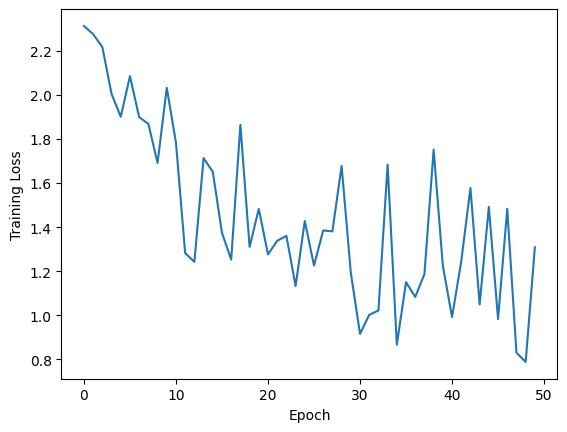

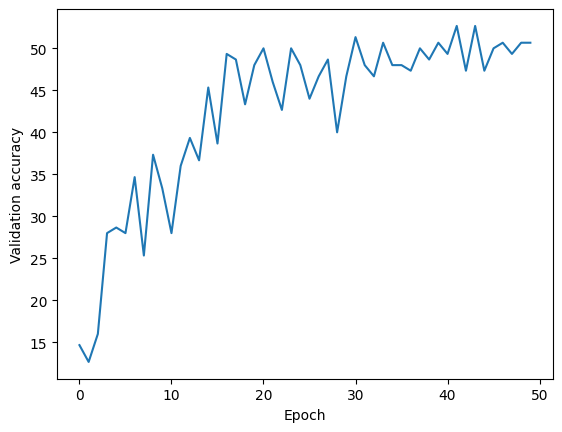

In [22]:
#Plot
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.show()

plt.plot(val_history)
plt.xlabel('Epoch')
plt.ylabel('Validation accuracy')
plt.show()

In [23]:
#Accuracy
test_acc = evaluate(model, test_loader, device)
print(f'Test set accuracy: {test_acc:.3f}%')

Test set accuracy: 66.667%


FMA Dataset


In [24]:
import pandas as pd

print("starting fma transfer...")

FMA_BASE = 'fma'
FMA_META = os.path.join(FMA_BASE, 'fma_metadata', 'tracks.csv')
FMA_ROOT = os.path.join(FMA_BASE, 'fma_small')

# meta
tracks = pd.read_csv(FMA_META, index_col=0, header=[0,1])
def col(a,b): return tracks[(a,b)]

mask_small = col('set','subset').eq('small')
has_top = col('track','genre_top').notna()
tracks_small = tracks[mask_small & has_top].copy()

split = col('set','split')[mask_small & has_top]
genre_top = col('track','genre_top')[mask_small & has_top]
classes = sorted(pd.unique(genre_top))
fma_label_map = {g:i for i,g in enumerate(classes)}

def fma_path(track_id: int):
    tid = f"{track_id:06d}"
    return os.path.join(FMA_ROOT, tid[:3], f"{tid}.mp3")

def collect(name):
    ids = tracks_small.index[split.eq(name)].tolist()
    files = [fma_path(i) for i in ids]
    labels = [fma_label_map[genre_top.loc[i]] for i in ids]
    return files, labels

fma_train_files, fma_train_labels = collect('training')
fma_val_files,   fma_val_labels   = collect('validation')
fma_test_files,  fma_test_labels  = collect('test')

class FMAAudioDataset(Dataset):
    def __init__(self, files, labels, sr=22050, duration=10, augment=True):
        self.files = files
        self.labels = labels
        self.sr = sr
        self.duration = duration
        self.augment = augment
        self.target_len = int(self.sr * self.duration)

    def __len__(self):
        return len(self.files)

    def _crop_or_pad(self, x):
        L = len(x)
        if L > self.target_len:
            start = np.random.randint(0, L - self.target_len + 1) if self.augment else (L - self.target_len)//2
            x = x[start:start + self.target_len]
        elif L < self.target_len:
            x = np.pad(x, (0, self.target_len - L))
        return x

    def _augment(self, x):
        if np.random.rand() < 0.7:
            n_steps = np.random.uniform(-2.0, 2.0)
            x = librosa.effects.pitch_shift(x, sr=self.sr, n_steps=n_steps)
        if np.random.rand() < 0.7 and len(x) > 2:
            rate = np.random.uniform(0.9, 1.1)
            x = librosa.effects.time_stretch(x, rate=rate)
        if np.random.rand() < 0.7:
            x = x * (0.8 + 0.4*np.random.rand())
        if np.random.rand() < 0.7:
            std = np.std(x)
            if std > 0:
                x = x + np.random.randn(*x.shape) * (0.01 * std)
        return x

    def __getitem__(self, idx):
        x, _ = librosa.load(self.files[idx], sr=self.sr, mono=True)

        if self.augment:
            x = self._augment(x)

        x = self._crop_or_pad(x)

        if len(x) != self.target_len:
            x = x[:self.target_len] if len(x) > self.target_len else np.pad(x, (0, self.target_len - len(x)))

        x = torch.from_numpy(x.astype(np.float32)).unsqueeze(0)  # (1, T)
        y = self.labels[idx]
        return x, y

train_fma_loader = DataLoader(FMAAudioDataset(fma_train_files, fma_train_labels, augment=True),
                              batch_size=batch_size, shuffle=True)
val_fma_loader   = DataLoader(FMAAudioDataset(fma_val_files,   fma_val_labels,   augment=False),
                              batch_size=batch_size, shuffle=False)
test_fma_loader  = DataLoader(FMAAudioDataset(fma_test_files,  fma_test_labels,  augment=False),
                              batch_size=batch_size, shuffle=False)

# model (same arch), swap head to FMA classes
transfer_model = oneDCNN(cin, cout, kernel_size, fdim, M, r).to(device)
transfer_model.fc2 = nn.Linear(M, len(fma_label_map)).to(device)

# load GTZAN weights except the final layer
pre = model.state_dict()
cur = transfer_model.state_dict()
for k, v in pre.items():
    if k.startswith('fc2.'):
        continue
    if k in cur and cur[k].shape == v.shape:
        cur[k] = v
transfer_model.load_state_dict(cur)

# fine-tune
opt_ft = optim.Adam(transfer_model.parameters(), lr=5e-4, weight_decay=lam)
ft_epochs = 10
for epoch in range(ft_epochs):
    transfer_model.train()
    for data, target in train_fma_loader:
        data, target = data.to(device), target.to(device)
        opt_ft.zero_grad()
        out = transfer_model(data)
        loss = nn.functional.cross_entropy(out, target)
        loss.backward()
        opt_ft.step()
    if (epoch + 1) % 5 == 0:
        val_acc = evaluate(transfer_model, val_fma_loader, device)
        print(f'FMA Epoch: {epoch + 1:d}. val_acc={val_acc:.2f}%')

final_acc = evaluate(transfer_model, test_fma_loader, device)
print(f'FMA test accuracy: {final_acc:.2f}%')


starting fma transfer...


FileNotFoundError: [Errno 2] No such file or directory: 'fma\\fma_metadata\\tracks.csv'